# C-mix model tutorial

We first import some necessary tools.

In [1]:
%reset -f
%matplotlib inline
%load_ext rpy2.ipython
import rpy2.robjects as ro
import numpy as np
import pylab as pl
import pandas as pd
from QNEM.inference import qnem
from QNEM.simulation import CensoredGeomMixtureRegression
from sklearn.cross_validation import ShuffleSplit
from sklearn.preprocessing import scale
from time import time

/Users/Simon/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Data generation

In [2]:
## Choose parameters ##
n_samples = 300           # number of patients
n_features = 100          # number of covariables
nb_active_features = 30   # number of active covariables
K = 1.                    # value of the active coefficients 
gap = .3                  # gap value to create high/low risk groups
rho = 0.5                 # coefficient of the toeplitz correlation matrix
r_cf = .5                 # confusion factors rate 
r_c = 0.5                 # censoring rate
pi0 = 0.75                # proportion of desired low risk patients rate
p0 = .01                  # geometric parameter for low risk patients
p1 = 0.5                  # geometric parameter for high risk patients
verbose = True            # verbose mode to detail or not ongoing tasks

simu = CensoredGeomMixtureRegression(verbose,n_samples,n_features,
                                     nb_active_features,K,rho,pi0,
                                     gap,r_c,r_cf,p0,p1)
X, Y, delta, Z, pi = simu.simulate()

-----------------------------------------------------------
Launching simulation using CensoredGeomMixtureRegression...
Done simulating using CensoredGeomMixtureRegression in 1.17e-01 seconds.


## Data splitting

In [3]:
## Assign index for each feature ##
features_names = range(X.shape[1]) 
n_samples, n_features = X.shape

## Split data into training and test sets ##
test_size = .3  # proportion of data used for testing
rs = ShuffleSplit(n_samples,n_iter=1,test_size=test_size,random_state=0)
for train_index, test_index in rs: 

    X_test = X[test_index]
    delta_test = delta[test_index]
    Y_test = Y[test_index]

    X = X[train_index]
    Y = Y[train_index]
    delta = delta[train_index]  
    
print "%d%% for training, %d%% for testing." % \
    ((1-test_size)*100,test_size*100)

70% for training, 30% for testing.


## Training 

In [4]:
## Choose parameters ##
tol = 1e-6            # tolerance for the convergence stopping criterion 
eta = 0.2             # parameter controlling the trade-off between l1 
                      # and l2 regularization in the elasticNet
intercept = True      # whether or not an intercept term is fitted
gamma_chosen ='1se'   # way to select l_elasticNet_chosen: '1se' or 'min'
warm_start = True     # at each L-BGFS-B iteration, reset beta to 0 or take 
                      # the previous value 
grid_size = 30        # grid size for the cross validation procedure
metric = 'C-index'    # cross-validation metric: 'log_lik' or 'C-index'
verbose = True 

## Choose between C-mix or CURE model ##
model = "C-mix"  # "C-mix", "CURE"       

if verbose:
    print ' '
    print "Launching %s..." % model
    print ' '

learner = qnem(l_elastic_net=0.,eta=eta,max_iter=100,tol=tol, 
               warm_start=warm_start,verbose=verbose,model=model, 
               intercept=intercept)
learner.n_features = n_features         

## Cross-validation ##
learner.cross_validate(X,Y,delta,n_folds=5,verbose=False,eta=eta, 
                       grid_size=grid_size,metric=metric)
avg_scores = learner.scores.mean(axis=1)
l_elastic_net_best = learner.l_elastic_net_best
if(gamma_chosen == '1se'):
    l_elastic_net_chosen = learner.l_elastic_net_chosen
if(gamma_chosen == 'min'):
    l_elastic_net_chosen = l_elastic_net_best
    
grid_elastic_net = learner.grid_elastic_net # get the cross-validation grid 
                                            # to plot learning curves

## Run selected model with l_elasticNet_chosen ##
learner = qnem(l_elastic_net=l_elastic_net_chosen,eta=eta,tol=tol,
               warm_start=warm_start,verbose=verbose,model=model,
               intercept=intercept)
learner.n_features = n_features
learner.fit(X,Y,delta)  

 
Launching C-mix...
 
Testing l_elastic_net=5.98e-05 on fold 0 1 2 3 4 : avg_score=8.34e-01
Testing l_elastic_net=8.22e-05 on fold 0 1 2 3 4 : avg_score=8.34e-01
Testing l_elastic_net=1.13e-04 on fold 0 1 2 3 4 : avg_score=8.34e-01
Testing l_elastic_net=1.55e-04 on fold 0 1 2 3 4 : avg_score=8.34e-01
Testing l_elastic_net=2.13e-04 on fold 0 1 2 3 4 : avg_score=8.34e-01
Testing l_elastic_net=2.93e-04 on fold 0 1 2 3 4 : avg_score=8.34e-01
Testing l_elastic_net=4.02e-04 on fold 0 1 2 3 4 : avg_score=8.34e-01
Testing l_elastic_net=5.52e-04 on fold 0 1 2 3 4 : avg_score=8.34e-01
Testing l_elastic_net=7.59e-04 on fold 0 1 2 3 4 : avg_score=8.34e-01
Testing l_elastic_net=1.04e-03 on fold 0 1 2 3 4 : avg_score=8.34e-01
Testing l_elastic_net=1.43e-03 on fold 0 1 2 3 4 : avg_score=8.34e-01
Testing l_elastic_net=1.97e-03 on fold 0 1 2 3 4 : avg_score=8.34e-01
Testing l_elastic_net=2.70e-03 on fold 0 1 2 3 4 : avg_score=8.34e-01
Testing l_elastic_net=3.71e-03 on fold 0 1 2 3 4 : avg_score=8.33e-

## Prediction

In [5]:
## Obtain the marker vector on test set ##
coeffs = learner.coeffs
marker = qnem.predict_proba(X_test,intercept,coeffs) 
c_index = qnem._c_index(Y_test,delta_test,marker)

print "Done predicting on test set."
print "C-index : %.2f" % c_index

Done predicting on test set.
C-index : 0.79


## Figures

### Learning curves

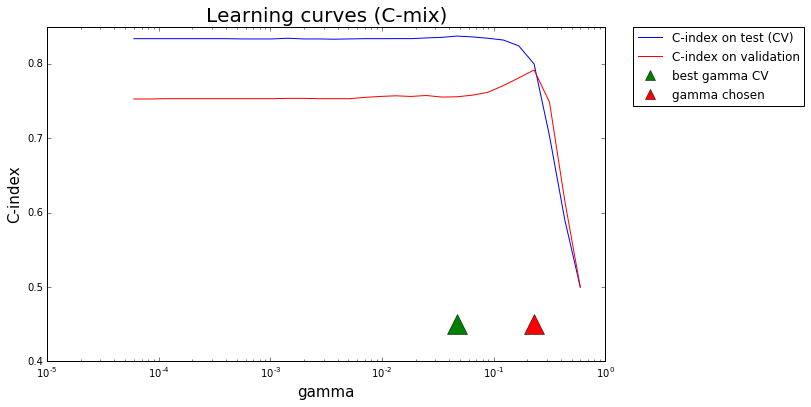

In [6]:
## Display learning curves ##
score_test = []
for idx_elastic_net, l_elastic_net in enumerate(grid_elastic_net):
    learner_ = qnem(verbose=False,l_elastic_net=l_elastic_net,
                    eta=eta,warm_start=warm_start,tol=tol,model=model,
                    intercept=intercept)
    learner_.n_features = n_features
    learner_.fit(X, Y, delta)
    if metric == 'log_lik':
        pc_ = 1./np.mean(T[delta==0])
        score_ = learner_._log_lik(X_test,Y_test,delta_test)              
    if metric == 'C-index':
        marker_ = qnem.predict_proba(X_test,intercept,learner_.coeffs)
        C_index_ = qnem._c_index(Y_test,delta_test,marker_) 
        score_ = max(C_index_,1-C_index_) # C-index in [.5,1]
    score_test.append(score_)

fig = pl.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(grid_elastic_net,avg_scores,label=metric + ' on test (CV)')
pl.xscale('log')
ax.plot(grid_elastic_net,score_test,'-r',label=metric + ' on validation')
y_min = ax.get_ylim()[0]
ax.plot(l_elastic_net_best,y_min,'g^',ms=20,label='best gamma CV')
ax.plot(l_elastic_net_chosen,y_min,'r^',ms=20,label='gamma chosen')
pl.title("Learning curves (%s)" % model,fontsize=20)
pl.xlabel('gamma',fontsize=15)
pl.ylabel(metric,fontsize=15)
pl.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0., 
          numpoints=1,markerscale=.5)

### Convergence

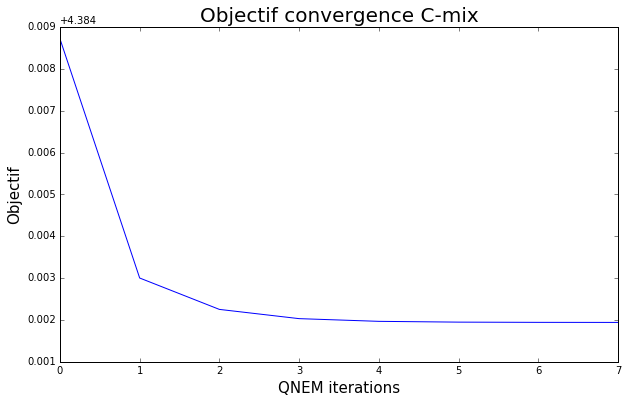

In [7]:
pl.figure(figsize=(10,6))
pl.title("Objectif convergence %s" % model,fontsize=20)
pl.xlabel('QNEM iterations',fontsize=15)
pl.ylabel('Objectif',fontsize=15)
pl.plot(learner.get_history("n_iter"),learner.get_history("obj"))

### Beta coefficients

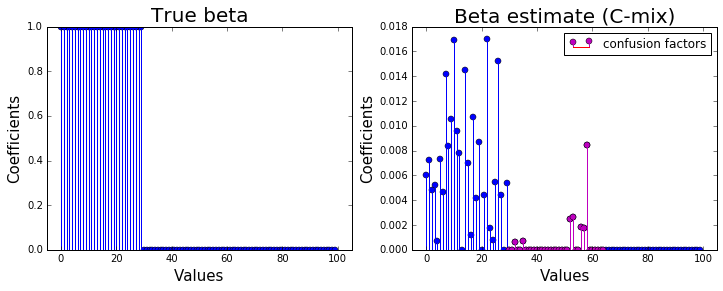

In [8]:
## True beta ##
beta = np.zeros(n_features)
beta[0:nb_active_features] = K
fig = pl.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)
ax1.stem(beta)
ax1.set_xlim([-5, len(beta)+5])
ax1.set_title("True beta",fontsize=20)
pl.xlabel('Values',fontsize=15)
pl.ylabel('Coefficients',fontsize=15)

## Beta estimate ##
if intercept:
    coeffs = coeffs[1:]
ax2 = fig.add_subplot(122)
ax2.stem(coeffs)
cf_end = nb_active_features+int((n_features-nb_active_features)*r_cf)
coeffs_cf = coeffs[nb_active_features:cf_end]
coeffs_cf = np.append(np.repeat([np.nan], nb_active_features),coeffs_cf)
ax2.stem(coeffs_cf,linefmt='m-',markerfmt='mo',label='confusion factors')
ax2.set_xlim([-5, len(coeffs)+5])
ax2.set_title("Beta estimate (%s)" % model,fontsize=20)
pl.xlabel('Values',fontsize=15)
pl.ylabel('Coefficients',fontsize=15)
pl.legend()
pl.show()

### AUC(t) curves

/Users/Simon/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: pec

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/Users/Simon/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: mvtnorm

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/Users/Simon/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: timereg

  res = super(Function, self).__call__(*new_args, **new_kwargs)


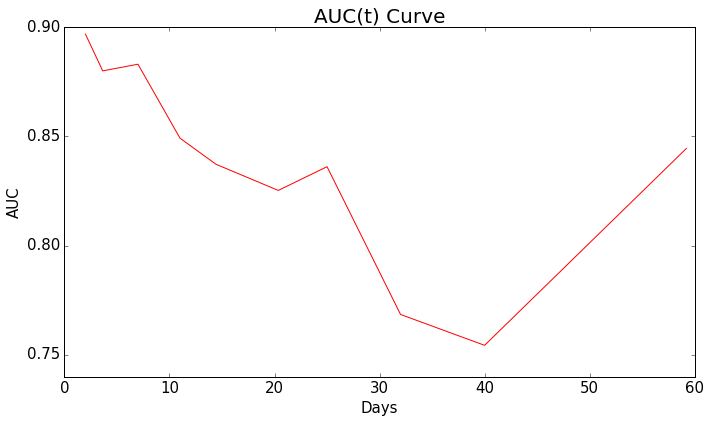

In [9]:
## Get T quantiles for AUC(t) ##
nb_t = 14 # desired number of quantiles
timesAUC = pd.DataFrame(Y).quantile(
            q = (1./nb_t + np.linspace(0,1,nb_t,endpoint=False))[1:-1]
                                    ).drop_duplicates().as_matrix()      

ro.globalenv['Y_test'] = Y_test
ro.globalenv['delta_test'] = delta_test
ro.globalenv['marker'] = marker
ro.globalenv['timesAUC'] = timesAUC
ro.r('library(timeROC)')
ro.r('auc_t = timeROC(Y_test,delta_test,marker,cause=1,times=timesAUC)')
auc_t = ro.r('auc_t$AUC')

auc_t = [max(val,1-val) for val in list(auc_t)]  # AUC(t) in [.5,1]

fig = pl.figure(figsize=(10,6)) 
ax = fig.add_subplot(111)
ax.tick_params(labelsize=15)
pl.title("AUC(t) Curve",fontsize=20)
pl.xlabel('Days',fontsize=15)
pl.ylabel('AUC',fontsize=15)
ax.plot(timesAUC,auc_t,'-r',label=model)
pl.tight_layout()
pl.show()